In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import singletask_dep as st
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'brk'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [13]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6779180010229038 	 Validation loss: 0.6692999510441796 	 
  1%|          | 574/57400 [00:05<08:20, 113.54it/s]
Epoch 2 	 Training loss: 0.6593304332540426 	 Validation loss: 0.6575344720129239 	 
  2%|▏         | 1148/57400 [00:11<08:36, 108.94it/s]
Epoch 3 	 Training loss: 0.6516745017796028 	 Validation loss: 0.6514716704012984 	 
  3%|▎         | 1722/57400 [00:16<08:14, 112.48it/s]
Epoch 4 	 Training loss: 0.6452357751359508 	 Validation loss: 0.6458590808561293 	 
  4%|▍         | 2296/57400 [00:22<08:12, 111.99it/s]
Epoch 5 	 Training loss: 0.6391127560196853 	 Validation loss: 0.6408236845064972 	 
  5%|▌         | 2870/57400 [00:27<07:56, 114.52it/s]
Epoch 6 	 Training loss: 0.6333518565116444 	 Validation loss: 0.6371575391898721 	 
  6%|▌         | 3444/57400 [00:33<07:58, 112.71it/s]
Epoch 7 	 Training loss: 0.6273534446435522 	 Validation loss: 0.6291580058760562 	 
  7%|▋         | 4018/57400 [00:38<07:48, 113.84it/s]
Epoch 8 	 Training loss: 0.6

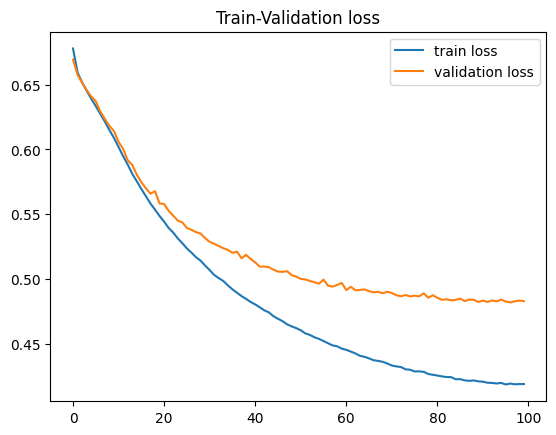

In [15]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7053571428571429, 'precision': 0.7053571428571429, 'f1': 0.7053571428571429, 'accuracy': 0.7053571428571429}
MALE {'recall': 0.8333333333333334, 'precision': 0.8333333333333334, 'f1': 0.8333333333333334, 'accuracy': 0.8333333333333334}
FEMALE {'recall': 0.5825, 'precision': 0.5825, 'f1': 0.5825, 'accuracy': 0.5825} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5643939393939394, 'precision': 0.5643939393939394, 'f1': 0.5643939393939394, 'accuracy': 0.5643939393939394}
MALE {'recall': 0.6885644768856448, 'precision': 0.6885644768856448, 'f1': 0.6885644768856448, 'accuracy': 0.6885644768856448}
FEMALE {'recall': 0.4304461942257218, 'precision': 0.4304461942257218, 'f1': 0.4304461942257218, 'accuracy': 0.4304461942257218} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6166883963494133, 'precision': 0.6166883963494133, 'f1': 0.6166883963494133, 'accuracy': 0.6166883963494133}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6799723076072719 	 Validation loss: 0.6793321482205795 	 
  1%|          | 574/57400 [00:05<08:17, 114.11it/s]
Epoch 2 	 Training loss: 0.6662441386163027 	 Validation loss: 0.6624783004744578 	 
  2%|▏         | 1148/57400 [00:10<08:21, 112.21it/s]
Epoch 3 	 Training loss: 0.6543550660593584 	 Validation loss: 0.6553168185686661 	 
  3%|▎         | 1722/57400 [00:16<08:21, 111.11it/s]
Epoch 4 	 Training loss: 0.6464562438921646 	 Validation loss: 0.6491307454594111 	 
  4%|▍         | 2296/57400 [00:21<08:08, 112.78it/s]
Epoch 5 	 Training loss: 0.6389111238904946 	 Validation loss: 0.6429502458895667 	 
  5%|▌         | 2870/57400 [00:27<07:55, 114.79it/s]
Epoch 6 	 Training loss: 0.6315202140849642 	 Validation loss: 0.6374895239280443 	 
  6%|▌         | 3444/57400 [00:32<08:07, 110.64it/s]
Epoch 7 	 Training loss: 0.6238104585778838 	 Validation loss: 0.631563112897388 	 
  7%|▋         | 4018/57400 [00:38<07:42, 115.40it/s]
Epoch 8 	 Training loss: 0.61

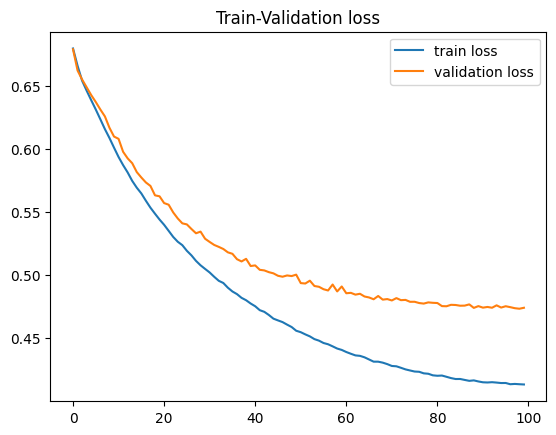

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7257653061224489, 'precision': 0.7257653061224489, 'f1': 0.725765306122449, 'accuracy': 0.7257653061224489}
MALE {'recall': 0.7942708333333334, 'precision': 0.7942708333333334, 'f1': 0.7942708333333333, 'accuracy': 0.7942708333333334}
FEMALE {'recall': 0.66, 'precision': 0.66, 'f1': 0.66, 'accuracy': 0.66} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5732323232323232, 'precision': 0.5732323232323232, 'f1': 0.5732323232323232, 'accuracy': 0.5732323232323232}
MALE {'recall': 0.6277372262773723, 'precision': 0.6277372262773723, 'f1': 0.6277372262773723, 'accuracy': 0.6277372262773723}
FEMALE {'recall': 0.5144356955380578, 'precision': 0.5144356955380578, 'f1': 0.5144356955380578, 'accuracy': 0.5144356955380578} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6205997392438071, 'precision': 0.6205997392438071, 'f1': 0.6205997392438071, 'accuracy': 0.6205997392438071}
MALE {'recall': 0.6439393

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6807301588590137 	 Validation loss: 0.6808933302507563 	 
  1%|          | 574/57400 [00:05<08:12, 115.39it/s]
Epoch 2 	 Training loss: 0.671232986533268 	 Validation loss: 0.6635632868540489 	 
  2%|▏         | 1148/57400 [00:10<08:19, 112.63it/s]
Epoch 3 	 Training loss: 0.6605325560328852 	 Validation loss: 0.6557923939268467 	 
  3%|▎         | 1722/57400 [00:16<08:10, 113.53it/s]
Epoch 4 	 Training loss: 0.6529199452973409 	 Validation loss: 0.6491547883567164 	 
  4%|▍         | 2296/57400 [00:21<08:15, 111.32it/s]
Epoch 5 	 Training loss: 0.6463914566546782 	 Validation loss: 0.6429737008224099 	 
  5%|▌         | 2870/57400 [00:27<08:06, 112.18it/s]
Epoch 6 	 Training loss: 0.6386805414530459 	 Validation loss: 0.6353536733126236 	 
  6%|▌         | 3444/57400 [00:32<07:54, 113.82it/s]
Epoch 7 	 Training loss: 0.6310134838474752 	 Validation loss: 0.6290712801076598 	 
  7%|▋         | 4018/57400 [00:38<07:54, 112.55it/s]
Epoch 8 	 Training loss: 0.62

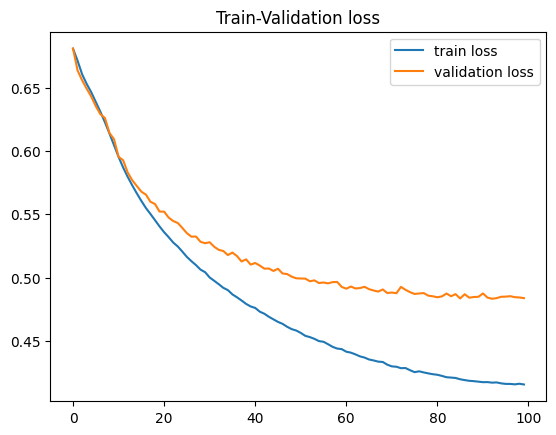

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7117346938775511, 'precision': 0.7117346938775511, 'f1': 0.7117346938775511, 'accuracy': 0.7117346938775511}
MALE {'recall': 0.8385416666666666, 'precision': 0.8385416666666666, 'f1': 0.8385416666666666, 'accuracy': 0.8385416666666666}
FEMALE {'recall': 0.59, 'precision': 0.59, 'f1': 0.59, 'accuracy': 0.59} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5820707070707071, 'precision': 0.5820707070707071, 'f1': 0.5820707070707071, 'accuracy': 0.5820707070707071}
MALE {'recall': 0.7153284671532847, 'precision': 0.7153284671532847, 'f1': 0.7153284671532847, 'accuracy': 0.7153284671532847}
FEMALE {'recall': 0.43832020997375326, 'precision': 0.43832020997375326, 'f1': 0.43832020997375326, 'accuracy': 0.43832020997375326} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.590612777053455, 'precision': 0.590612777053455, 'f1': 0.590612777053455, 'accuracy': 0.590612777053455}
MALE {'recall': 0.714646

In [21]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7142857142857143, 'precision': 0.7142857142857143, 'f1': 0.7142857142857143, 'accuracy': 0.7142857142857143}
Métricas etiqueta male: {'recall': 0.8220486111111112, 'precision': 0.8220486111111112, 'f1': 0.822048611111111, 'accuracy': 0.8220486111111112}
Métricas etiqueta female:  {'recall': 0.6108333333333333, 'precision': 0.6108333333333333, 'f1': 0.6108333333333333, 'accuracy': 0.6108333333333333}

 to
Resultado global: {'recall': 0.5732323232323232, 'precision': 0.5732323232323232, 'f1': 0.5732323232323232, 'accuracy': 0.5732323232323232}
Métricas etiqueta male: {'recall': 0.6772100567721006, 'precision': 0.6772100567721006, 'f1': 0.6772100567721006, 'accuracy': 0.6772100567721006}
Métricas etiqueta female:  {'recall': 0.46106736657917763, 'precision': 0.46106736657917763, 'f1': 0.46106736657917763, 'accuracy': 0.46106736657917763}

 as
Resultado global: {'recall': 0.6093003042155585, 'precision': 0.6093003042155585, 'f1': 

## TO

In [22]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693337457624462 	 Validation loss: 0.6942247394788064 	 
  1%|          | 574/57400 [00:06<09:21, 101.17it/s]
Epoch 2 	 Training loss: 0.6932429824971986 	 Validation loss: 0.6929620918581041 	 
  2%|▏         | 1148/57400 [00:12<09:12, 101.85it/s]
Epoch 3 	 Training loss: 0.6930902493332322 	 Validation loss: 0.6933407561253693 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<08:57, 103.56it/s]
Epoch 4 	 Training loss: 0.693153615301079 	 Validation loss: 0.6921316991418095 	 
  4%|▍         | 2296/57400 [00:24<09:01, 101.69it/s]
Epoch 5 	 Training loss: 0.6931570204500538 	 Validation loss: 0.6939942776146582 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:44, 103.96it/s]
Epoch 6 	 Training loss: 0.6931016364164053 	 Validation loss: 0.6932213690321324 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:36<08:49, 101.82it/s]
Epoch 7 	 Training loss: 0.6931094357983991 	 Validation loss: 0.6941042481842687 

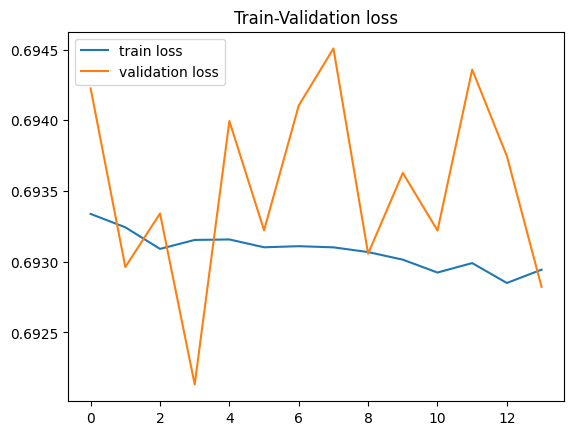

In [23]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5165816326530612, 'precision': 0.5165816326530612, 'f1': 0.5165816326530612, 'accuracy': 0.5165816326530612}
MALE {'recall': 0.059895833333333336, 'precision': 0.059895833333333336, 'f1': 0.059895833333333336, 'accuracy': 0.059895833333333336}
FEMALE {'recall': 0.955, 'precision': 0.955, 'f1': 0.955, 'accuracy': 0.955} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4861111111111111, 'precision': 0.4861111111111111, 'f1': 0.4861111111111111, 'accuracy': 0.4861111111111111}
MALE {'recall': 0.0705596107055961, 'precision': 0.0705596107055961, 'f1': 0.0705596107055961, 'accuracy': 0.0705596107055961}
FEMALE {'recall': 0.9343832020997376, 'precision': 0.9343832020997376, 'f1': 0.9343832020997376, 'accuracy': 0.9343832020997376} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4758800521512386, 'precision': 0.4758800521512386, 'f1': 0.4758800521512386, 'accuracy': 0.4758800521512386}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933079969384529 	 Validation loss: 0.6931726871910742 	 
  1%|          | 574/57400 [00:06<09:14, 102.46it/s]
Epoch 2 	 Training loss: 0.6932506801151648 	 Validation loss: 0.6930182091260361 	 
  2%|▏         | 1148/57400 [00:12<09:18, 100.70it/s]
Epoch 3 	 Training loss: 0.693140876002428 	 Validation loss: 0.6930392748218471 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:09, 101.41it/s]
Epoch 4 	 Training loss: 0.6931964823593246 	 Validation loss: 0.6930612123618691 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:24<08:51, 103.68it/s]
Epoch 5 	 Training loss: 0.6932013525987751 	 Validation loss: 0.6924693180342852 	 
  5%|▌         | 2870/57400 [00:30<08:59, 101.12it/s]
Epoch 6 	 Training loss: 0.6931214548569523 	 Validation loss: 0.6930548932592747 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:36<08:49, 101.81it/s]
Epoch 7 	 Training loss: 0.6932211512057208 	 Validation loss: 0.6927907093096588

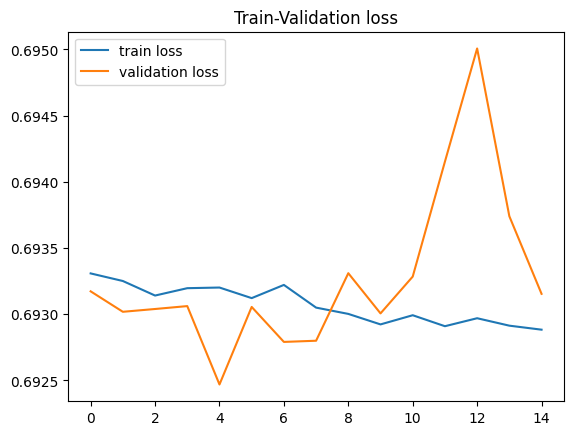

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5229591836734694, 'precision': 0.5229591836734694, 'f1': 0.5229591836734694, 'accuracy': 0.5229591836734694}
MALE {'recall': 0.06510416666666667, 'precision': 0.06510416666666667, 'f1': 0.06510416666666667, 'accuracy': 0.06510416666666667}
FEMALE {'recall': 0.9625, 'precision': 0.9625, 'f1': 0.9625000000000001, 'accuracy': 0.9625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5012626262626263, 'precision': 0.5012626262626263, 'f1': 0.5012626262626263, 'accuracy': 0.5012626262626263}
MALE {'recall': 0.09245742092457421, 'precision': 0.09245742092457421, 'f1': 0.09245742092457421, 'accuracy': 0.09245742092457421}
FEMALE {'recall': 0.9422572178477691, 'precision': 0.9422572178477691, 'f1': 0.9422572178477691, 'accuracy': 0.9422572178477691} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.47979139504563234, 'precision': 0.47979139504563234, 'f1': 0.47979139504563234, 'accuracy': 0.47979139504

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693269381435906 	 Validation loss: 0.6920051534297103 	 
  1%|          | 574/57400 [00:06<09:24, 100.72it/s]
Epoch 2 	 Training loss: 0.6932363100998908 	 Validation loss: 0.693528180405245 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:09, 102.39it/s]
Epoch 3 	 Training loss: 0.6930669276141124 	 Validation loss: 0.6932407213469683 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:09, 101.25it/s]
Epoch 4 	 Training loss: 0.6931438598690963 	 Validation loss: 0.6931608713279336 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:05, 100.96it/s]
Epoch 5 	 Training loss: 0.6929635509381311 	 Validation loss: 0.6942475175453444 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:47, 103.33it/s]
Epoch 6 	 Training loss: 0.6928982238320939 	 Validation loss: 0.6937528788033178 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:36<08:51, 101.52it/s]
Epoch 7 	 Training loss:

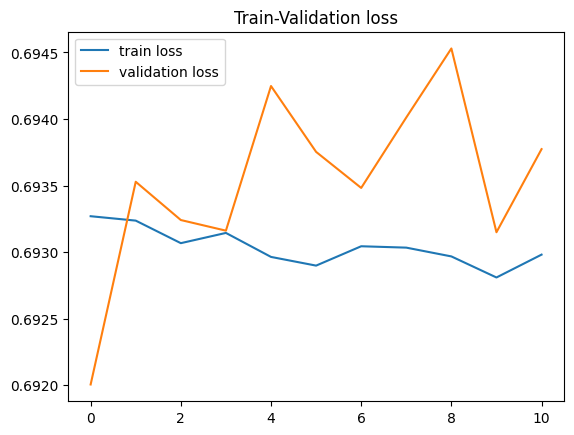

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5089285714285714, 'precision': 0.5089285714285714, 'f1': 0.5089285714285714, 'accuracy': 0.5089285714285714}
MALE {'recall': 0.0026041666666666665, 'precision': 0.0026041666666666665, 'f1': 0.0026041666666666665, 'accuracy': 0.0026041666666666665}
FEMALE {'recall': 0.995, 'precision': 0.995, 'f1': 0.995, 'accuracy': 0.995} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4823232323232323, 'precision': 0.4823232323232323, 'f1': 0.4823232323232323, 'accuracy': 0.4823232323232323}
MALE {'recall': 0.004866180048661801, 'precision': 0.004866180048661801, 'f1': 0.004866180048661801, 'accuracy': 0.004866180048661801}
FEMALE {'recall': 0.9973753280839895, 'precision': 0.9973753280839895, 'f1': 0.9973753280839895, 'accuracy': 0.9973753280839895} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.483702737940026

In [29]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.516156462585034, 'precision': 0.516156462585034, 'f1': 0.516156462585034, 'accuracy': 0.516156462585034}
Métricas etiqueta male: {'recall': 0.042534722222222224, 'precision': 0.042534722222222224, 'f1': 0.042534722222222224, 'accuracy': 0.042534722222222224}
Métricas etiqueta female:  {'recall': 0.9708333333333333, 'precision': 0.9708333333333333, 'f1': 0.9708333333333333, 'accuracy': 0.9708333333333333}

 to
Resultado global: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
Métricas etiqueta male: {'recall': 0.05596107055961071, 'precision': 0.05596107055961071, 'f1': 0.05596107055961071, 'accuracy': 0.05596107055961071}
Métricas etiqueta female:  {'recall': 0.958005249343832, 'precision': 0.958005249343832, 'f1': 0.958005249343832, 'accuracy': 0.958005249343832}

 as
Resultado global: {'recall': 0.47979139504563234, 'precision': 0.47979139504563234, 'f1

# AS

In [30]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932950430007762 	 Validation loss: 0.6927594249531374 	 
  1%|          | 574/57400 [00:06<09:19, 101.52it/s]
Epoch 2 	 Training loss: 0.6932430306793506 	 Validation loss: 0.692943064843194 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:16, 101.01it/s]
Epoch 3 	 Training loss: 0.6931279681700863 	 Validation loss: 0.6934976517143896 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:04, 102.23it/s]
Epoch 4 	 Training loss: 0.6930801735522439 	 Validation loss: 0.6939853793483669 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:03, 101.37it/s]
Epoch 5 	 Training loss: 0.6931112720160534 	 Validation loss: 0.6928475943662352 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:59, 101.11it/s]
Epoch 6 	 Training loss: 0.6930282527146023 	 Validation loss: 0.6933006896811017 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:36<08:41, 103.37it/s]
Epoch 7 	 Training loss

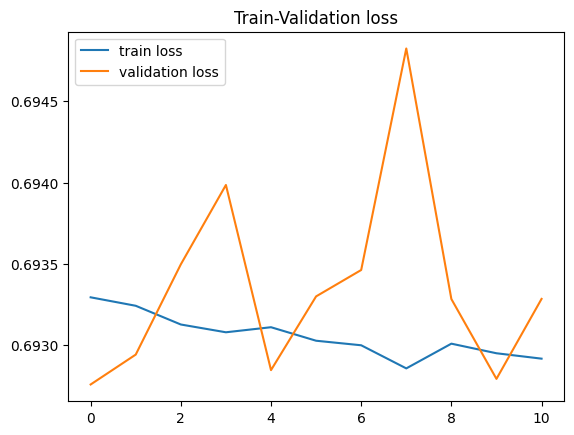

In [31]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49362244897959184, 'precision': 0.49362244897959184, 'f1': 0.49362244897959184, 'accuracy': 0.49362244897959184}
MALE {'recall': 0.09635416666666667, 'precision': 0.09635416666666667, 'f1': 0.09635416666666666, 'accuracy': 0.09635416666666667}
FEMALE {'recall': 0.875, 'precision': 0.875, 'f1': 0.875, 'accuracy': 0.875} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.09732360097323602, 'precision': 0.09732360097323602, 'f1': 0.09732360097323602, 'accuracy': 0.09732360097323602}
FEMALE {'recall': 0.89501312335958, 'precision': 0.89501312335958, 'f1': 0.89501312335958, 'accuracy': 0.89501312335958} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.485006518904824, 'precision': 0.485006518904824, 'f1': 0.485006518904824, 'accuracy': 0.485006518904824}
MALE {'recall': 0.08

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693355302673599 	 Validation loss: 0.6939023359347198 	 
  1%|          | 574/57400 [00:06<09:10, 103.20it/s]
Epoch 2 	 Training loss: 0.6932504519768293 	 Validation loss: 0.6923282277786126 	 
  2%|▏         | 1148/57400 [00:12<09:15, 101.22it/s]
Epoch 3 	 Training loss: 0.6931456636884071 	 Validation loss: 0.692954724117861 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:10, 101.22it/s]
Epoch 4 	 Training loss: 0.6931898993689839 	 Validation loss: 0.6926533529313944 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:01, 101.72it/s]
Epoch 5 	 Training loss: 0.6930458914319813 	 Validation loss: 0.6925071114200657 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:48, 103.13it/s]
Epoch 6 	 Training loss: 0.6929301573839752 	 Validation loss: 0.6922857266361431 	 
  6%|▌         | 3444/57400 [00:36<08:38, 104.15it/s]
Epoch 7 	 Training loss: 0.6929903928618814 	 Validation loss: 0.6931415260848353 

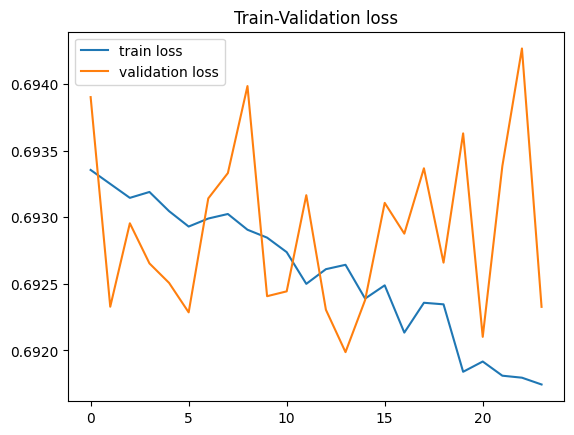

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4732142857142857, 'precision': 0.4732142857142857, 'f1': 0.4732142857142857, 'accuracy': 0.4732142857142857}
MALE {'recall': 0.5989583333333334, 'precision': 0.5989583333333334, 'f1': 0.5989583333333334, 'accuracy': 0.5989583333333334}
FEMALE {'recall': 0.3525, 'precision': 0.3525, 'f1': 0.3525, 'accuracy': 0.3525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 0.6593673965936739, 'precision': 0.6593673965936739, 'f1': 0.6593673965936739, 'accuracy': 0.6593673965936739}
FEMALE {'recall': 0.3700787401574803, 'precision': 0.3700787401574803, 'f1': 0.37007874015748027, 'accuracy': 0.3700787401574803} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5267275097783573, 'precision': 0.5267275097783573, 'f1': 0.5267275097783573, 'accuracy': 0.5267275097783573}
MALE {'recall':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933429472745504 	 Validation loss: 0.692972028659562 	 
  1%|          | 574/57400 [00:06<09:23, 100.78it/s]
Epoch 2 	 Training loss: 0.6932100423121702 	 Validation loss: 0.6932069346056147 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:01, 103.95it/s]
Epoch 3 	 Training loss: 0.6930512780719518 	 Validation loss: 0.6929827675981036 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:12, 100.72it/s]
Epoch 4 	 Training loss: 0.6930378838490941 	 Validation loss: 0.6939504671905 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:06, 100.82it/s]
Epoch 5 	 Training loss: 0.6930499242988613 	 Validation loss: 0.6920542413905516 	 
  5%|▌         | 2870/57400 [00:30<08:47, 103.38it/s]
Epoch 6 	 Training loss: 0.6929238228847756 	 Validation loss: 0.6924479826022003 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:36<08:54, 100.90it/s]
Epoch 7 	 Training loss: 0.6928827244437945 	 Validatio

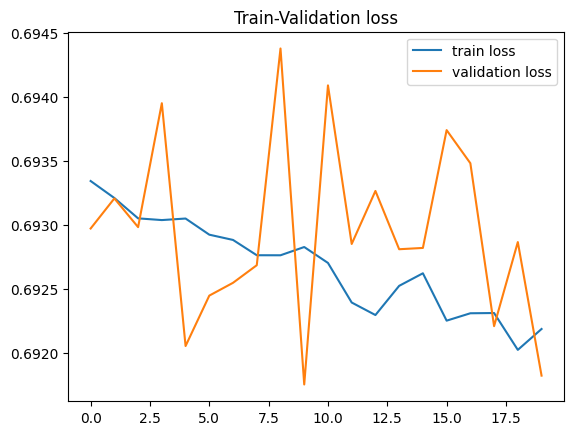

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5025510204081632, 'precision': 0.5025510204081632, 'f1': 0.5025510204081632, 'accuracy': 0.5025510204081632}
MALE {'recall': 0.171875, 'precision': 0.171875, 'f1': 0.171875, 'accuracy': 0.171875}
FEMALE {'recall': 0.82, 'precision': 0.82, 'f1': 0.82, 'accuracy': 0.82} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4797979797979798, 'precision': 0.4797979797979798, 'f1': 0.4797979797979798, 'accuracy': 0.4797979797979798}
MALE {'recall': 0.1386861313868613, 'precision': 0.1386861313868613, 'f1': 0.1386861313868613, 'accuracy': 0.1386861313868613}
FEMALE {'recall': 0.847769028871391, 'precision': 0.847769028871391, 'f1': 0.847769028871391, 'accuracy': 0.847769028871391} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49674054758800523, 'precision': 0.49674054758800523, 'f1': 0.49674054758800523, 'accuracy': 0.49674054758800523}
MALE {'recall': 0.18434343434343434, 'precision': 0.184343434343

In [37]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
Métricas etiqueta male: {'recall': 0.2890625, 'precision': 0.2890625, 'f1': 0.2890625, 'accuracy': 0.2890625}
Métricas etiqueta female:  {'recall': 0.6825, 'precision': 0.6825, 'f1': 0.6825, 'accuracy': 0.6825}

 to
Resultado global: {'recall': 0.4936868686868687, 'precision': 0.4936868686868687, 'f1': 0.4936868686868687, 'accuracy': 0.4936868686868687}
Métricas etiqueta male: {'recall': 0.2984590429845904, 'precision': 0.2984590429845904, 'f1': 0.2984590429845904, 'accuracy': 0.2984590429845904}
Métricas etiqueta female:  {'recall': 0.7042869641294838, 'precision': 0.7042869641294838, 'f1': 0.7042869641294838, 'accuracy': 0.7042869641294838}

 as
Resultado global: {'recall': 0.5028248587570622, 'precision': 0.5028248587570622, 'f1': 0.5028248587570622, 'accuracy': 0.5028248587570622}
Métricas etiqueta male: {'recall': 

# Pruebas hiperparámetros 2

In [38]:
emb_dim = 20
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 64

## ABOUT

In [39]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6805779971312147 	 Validation loss: 0.6801607689615023 	 
  1%|          | 574/57400 [00:04<06:41, 141.66it/s]
Epoch 2 	 Training loss: 0.6708244768584647 	 Validation loss: 0.6624699770394018 	 
  2%|▏         | 1148/57400 [00:08<06:36, 141.72it/s]
Epoch 3 	 Training loss: 0.6524528220347826 	 Validation loss: 0.652791800135273 	 
  3%|▎         | 1722/57400 [00:12<06:32, 141.73it/s]
Epoch 4 	 Training loss: 0.6435713122115317 	 Validation loss: 0.6480868317313113 	 
  4%|▍         | 2296/57400 [00:17<06:19, 145.08it/s]
Epoch 5 	 Training loss: 0.6366497744458893 	 Validation loss: 0.6418598950919459 	 
  5%|▌         | 2870/57400 [00:21<06:22, 142.60it/s]
Epoch 6 	 Training loss: 0.6301724751859592 	 Validation loss: 0.6361691113245689 	 
  6%|▌         | 3444/57400 [00:25<06:12, 144.73it/s]
Epoch 7 	 Training loss: 0.6235677117046994 	 Validation loss: 0.6309513924485546 	 
  7%|▋         | 4018/57400 [00:30<06:12, 143.17it/s]
Epoch 8 	 Training loss: 0.61

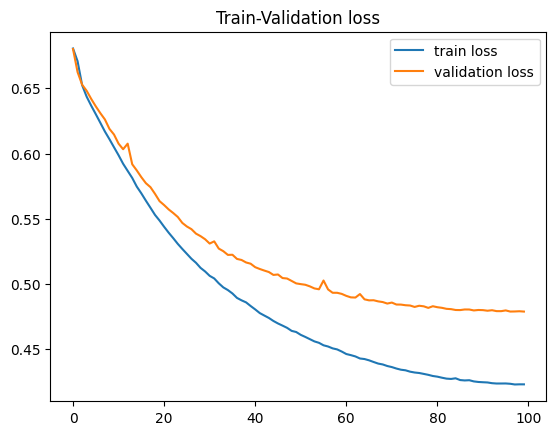

In [40]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [41]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7155612244897959, 'precision': 0.7155612244897959, 'f1': 0.7155612244897959, 'accuracy': 0.7155612244897959}
MALE {'recall': 0.7734375, 'precision': 0.7734375, 'f1': 0.7734375, 'accuracy': 0.7734375}
FEMALE {'recall': 0.66, 'precision': 0.66, 'f1': 0.66, 'accuracy': 0.66} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5568181818181818, 'precision': 0.5568181818181818, 'f1': 0.5568181818181818, 'accuracy': 0.5568181818181818}
MALE {'recall': 0.6058394160583942, 'precision': 0.6058394160583942, 'f1': 0.6058394160583942, 'accuracy': 0.6058394160583942}
FEMALE {'recall': 0.5039370078740157, 'precision': 0.5039370078740157, 'f1': 0.5039370078740157, 'accuracy': 0.5039370078740157} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5788787483702738, 'precision': 0.5788787483702738, 'f1': 0.5788787483702738, 'accuracy': 0.5788787483702738}
MALE {'recall': 0.6060606060606061, 'precision': 0.606060606

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6806601402236194 	 Validation loss: 0.6827383788965516 	 
  1%|          | 574/57400 [00:04<06:40, 141.87it/s]
Epoch 2 	 Training loss: 0.6769037474115551 	 Validation loss: 0.6730135153915923 	 
  2%|▏         | 1148/57400 [00:08<06:35, 142.27it/s]
Epoch 3 	 Training loss: 0.6613168336373173 	 Validation loss: 0.6499798479726759 	 
  3%|▎         | 1722/57400 [00:13<06:32, 141.71it/s]
Epoch 4 	 Training loss: 0.6462660120339344 	 Validation loss: 0.6395653243792259 	 
  4%|▍         | 2296/57400 [00:17<06:30, 141.05it/s]
Epoch 5 	 Training loss: 0.6378331699437796 	 Validation loss: 0.6318504628488573 	 
  5%|▌         | 2870/57400 [00:21<06:18, 143.99it/s]
Epoch 6 	 Training loss: 0.6307609112420564 	 Validation loss: 0.6280538237701028 	 
  6%|▌         | 3444/57400 [00:26<06:11, 145.25it/s]
Epoch 7 	 Training loss: 0.6235031738929216 	 Validation loss: 0.6210804935229026 	 
  7%|▋         | 4018/57400 [00:30<06:15, 142.06it/s]
Epoch 8 	 Training loss: 0.6

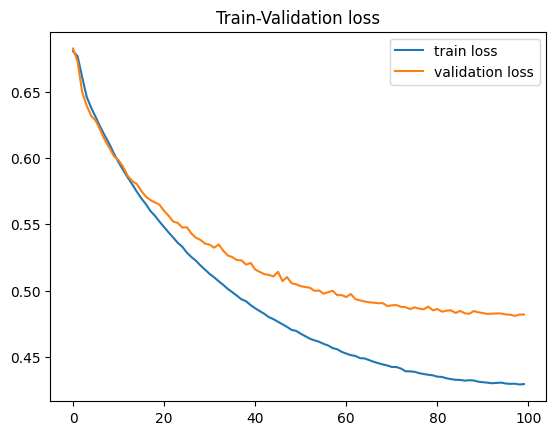

In [42]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [43]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7193877551020408, 'precision': 0.7193877551020408, 'f1': 0.7193877551020408, 'accuracy': 0.7193877551020408}
MALE {'recall': 0.8203125, 'precision': 0.8203125, 'f1': 0.8203125, 'accuracy': 0.8203125}
FEMALE {'recall': 0.6225, 'precision': 0.6225, 'f1': 0.6225, 'accuracy': 0.6225} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6136363636363636, 'precision': 0.6136363636363636, 'f1': 0.6136363636363636, 'accuracy': 0.6136363636363636}
MALE {'recall': 0.7226277372262774, 'precision': 0.7226277372262774, 'f1': 0.7226277372262774, 'accuracy': 0.7226277372262774}
FEMALE {'recall': 0.49606299212598426, 'precision': 0.49606299212598426, 'f1': 0.49606299212598426, 'accuracy': 0.49606299212598426} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6023468057366362, 'precision': 0.6023468057366362, 'f1': 0.6023468057366362, 'accuracy': 0.6023468057366362}
MALE {'recall': 0.6641414141414141, 'precision':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6802922466490742 	 Validation loss: 0.6792721283637871 	 
  1%|          | 574/57400 [00:04<06:44, 140.45it/s]
Epoch 2 	 Training loss: 0.6679415853389049 	 Validation loss: 0.662615548756163 	 
  2%|▏         | 1148/57400 [00:08<06:38, 141.03it/s]
Epoch 3 	 Training loss: 0.6518667732797018 	 Validation loss: 0.6561238927356268 	 
  3%|▎         | 1722/57400 [00:12<06:28, 143.47it/s]
Epoch 4 	 Training loss: 0.6429542284393975 	 Validation loss: 0.6512642482579765 	 
  4%|▍         | 2296/57400 [00:17<06:31, 140.87it/s]
Epoch 5 	 Training loss: 0.6358082411804266 	 Validation loss: 0.6450750757071931 	 
  5%|▌         | 2870/57400 [00:21<06:19, 143.58it/s]
Epoch 6 	 Training loss: 0.6292469137013997 	 Validation loss: 0.6410599573183868 	 
  6%|▌         | 3444/57400 [00:25<06:14, 144.25it/s]
Epoch 7 	 Training loss: 0.6236314269931474 	 Validation loss: 0.6345237301567853 	 
  7%|▋         | 4018/57400 [00:30<06:13, 142.88it/s]
Epoch 8 	 Training loss: 0.61

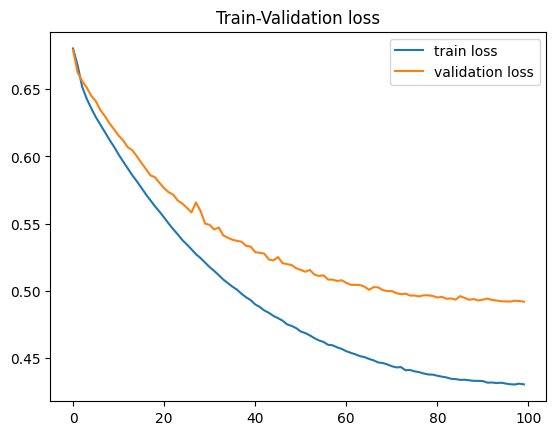

In [44]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [45]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7091836734693877, 'precision': 0.7091836734693877, 'f1': 0.7091836734693878, 'accuracy': 0.7091836734693877}
MALE {'recall': 0.8125, 'precision': 0.8125, 'f1': 0.8125, 'accuracy': 0.8125}
FEMALE {'recall': 0.61, 'precision': 0.61, 'f1': 0.61, 'accuracy': 0.61} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5542929292929293, 'precision': 0.5542929292929293, 'f1': 0.5542929292929293, 'accuracy': 0.5542929292929293}
MALE {'recall': 0.635036496350365, 'precision': 0.635036496350365, 'f1': 0.635036496350365, 'accuracy': 0.635036496350365}
FEMALE {'recall': 0.4671916010498688, 'precision': 0.4671916010498688, 'f1': 0.4671916010498688, 'accuracy': 0.4671916010498688} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5880052151238592, 'precision': 0.5880052151238592, 'f1': 0.5880052151238592, 'accuracy': 0.5880052151238592}
MALE {'recall': 0.6060606060606061, 'precision': 0.6060606060606061, 'f1': 0

In [46]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7147108843537414, 'precision': 0.7147108843537414, 'f1': 0.7147108843537415, 'accuracy': 0.7147108843537414}
Métricas etiqueta male: {'recall': 0.8020833333333334, 'precision': 0.8020833333333334, 'f1': 0.8020833333333334, 'accuracy': 0.8020833333333334}
Métricas etiqueta female:  {'recall': 0.6308333333333334, 'precision': 0.6308333333333334, 'f1': 0.6308333333333334, 'accuracy': 0.6308333333333334}

 to
Resultado global: {'recall': 0.5749158249158249, 'precision': 0.5749158249158249, 'f1': 0.5749158249158249, 'accuracy': 0.5749158249158249}
Métricas etiqueta male: {'recall': 0.6545012165450121, 'precision': 0.6545012165450121, 'f1': 0.6545012165450121, 'accuracy': 0.6545012165450121}
Métricas etiqueta female:  {'recall': 0.4890638670166229, 'precision': 0.4890638670166229, 'f1': 0.4890638670166229, 'accuracy': 0.4890638670166229}

 as
Resultado global: {'recall': 0.5897435897435898, 'precision': 0.5897435897435898, 'f1': 0.5

## TO

In [47]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933113113305295 	 Validation loss: 0.693861377441277 	 
  1%|          | 574/57400 [00:05<07:49, 120.94it/s]
Epoch 2 	 Training loss: 0.6931236863967019 	 Validation loss: 0.6945699776633311 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:10<07:35, 123.52it/s]
Epoch 3 	 Training loss: 0.693191881379184 	 Validation loss: 0.6914351491604821 	 
  3%|▎         | 1722/57400 [00:15<07:34, 122.43it/s]
Epoch 4 	 Training loss: 0.6931314736293168 	 Validation loss: 0.6924177802215188 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:28, 122.83it/s]
Epoch 5 	 Training loss: 0.693203990779272 	 Validation loss: 0.6932167309825703 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:21, 123.42it/s]
Epoch 6 	 Training loss: 0.6931800056209962 	 Validation loss: 0.6930195406331854 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:14, 124.16it/s]
Epoch 7 	 Training loss: 0.6929895510241545 	 Validati

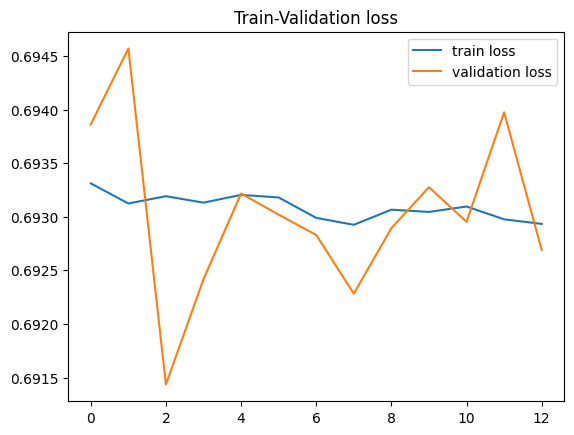

In [48]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [49]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.485006518904824, 'precision': 0.485006518904824, 'f1': 0.485006518904824, 'accuracy': 0.485006518904824}
MALE {'recall': 0.0025252525252525255, 'precision': 0.0025252525252525255, 'f1': 0.0025252525252525255, 'accuracy': 0.0025252525252525255}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932738323660262 	 Validation loss: 0.693708281395799 	 
  1%|          | 574/57400 [00:05<07:45, 122.13it/s]
Epoch 2 	 Training loss: 0.6932515682659083 	 Validation loss: 0.6934961040141219 	 
  2%|▏         | 1148/57400 [00:10<07:39, 122.29it/s]
Epoch 3 	 Training loss: 0.6931947145727869 	 Validation loss: 0.6928295765892934 	 
  3%|▎         | 1722/57400 [00:15<07:36, 122.04it/s]
Epoch 4 	 Training loss: 0.6931155993755687 	 Validation loss: 0.6929788427837824 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:29, 122.49it/s]
Epoch 5 	 Training loss: 0.6930043991226768 	 Validation loss: 0.6918063759803772 	 
  5%|▌         | 2870/57400 [00:25<07:28, 121.58it/s]
Epoch 6 	 Training loss: 0.6931086399621664 	 Validation loss: 0.6939643874006757 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:24, 121.47it/s]
Epoch 7 	 Training loss: 0.6931353640265581 	 Validation loss: 0.6932251099812783 	 

2 epoch without improvem

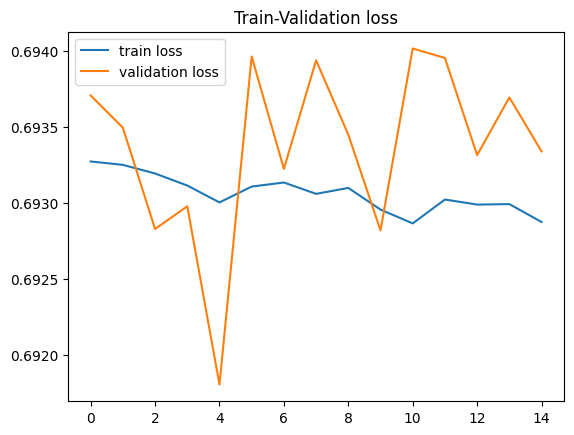

In [50]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [51]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.0078125, 'precision': 0.0078125, 'f1': 0.0078125, 'accuracy': 0.0078125}
FEMALE {'recall': 0.9875, 'precision': 0.9875, 'f1': 0.9875, 'accuracy': 0.9875} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47853535353535354, 'precision': 0.47853535353535354, 'f1': 0.47853535353535354, 'accuracy': 0.47853535353535354}
MALE {'recall': 0.012165450121654502, 'precision': 0.012165450121654502, 'f1': 0.012165450121654502, 'accuracy': 0.012165450121654502}
FEMALE {'recall': 0.9816272965879265, 'precision': 0.9816272965879265, 'f1': 0.9816272965879265, 'accuracy': 0.9816272965879265} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'recall': 0.007575757575757576, 'p

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933141883449687 	 Validation loss: 0.6926465276944436 	 
  1%|          | 574/57400 [00:05<07:46, 121.81it/s]
Epoch 2 	 Training loss: 0.6931554748829234 	 Validation loss: 0.692534224461701 	 
  2%|▏         | 1148/57400 [00:10<07:38, 122.57it/s]
Epoch 3 	 Training loss: 0.6931933721183484 	 Validation loss: 0.6932105593762156 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:32, 123.15it/s]
Epoch 4 	 Training loss: 0.6931835904146321 	 Validation loss: 0.6933319558531551 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:28, 122.97it/s]
Epoch 5 	 Training loss: 0.6930409831867816 	 Validation loss: 0.6926705746327416 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:30, 121.17it/s]
Epoch 6 	 Training loss: 0.693036559255281 	 Validation loss: 0.693871856746027 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:16, 123.69it/s]
Epoch 7 	 Training loss: 0.692999136884038 	 Validatio

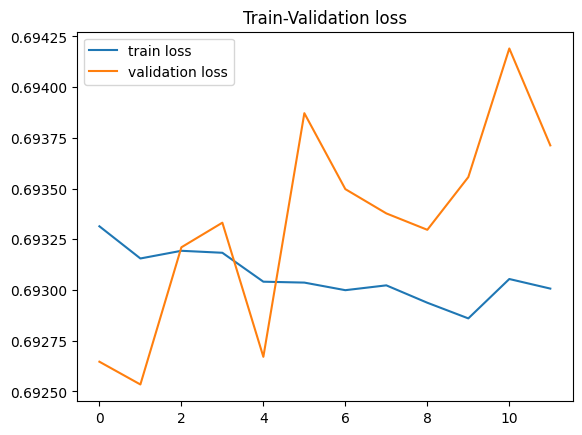

In [52]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [53]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.514030612244898, 'precision': 0.514030612244898, 'f1': 0.514030612244898, 'accuracy': 0.514030612244898}
MALE {'recall': 0.0390625, 'precision': 0.0390625, 'f1': 0.0390625, 'accuracy': 0.0390625}
FEMALE {'recall': 0.97, 'precision': 0.97, 'f1': 0.97, 'accuracy': 0.97} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.058394160583941604, 'precision': 0.058394160583941604, 'f1': 0.058394160583941604, 'accuracy': 0.058394160583941604}
FEMALE {'recall': 0.937007874015748, 'precision': 0.937007874015748, 'f1': 0.9370078740157481, 'accuracy': 0.937007874015748} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.48239895697522817, 'accuracy': 0.48239895697522817}
MALE {'recall': 0.03535353535353535, 'precision': 0.035

In [54]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5106292517006803, 'precision': 0.5106292517006803, 'f1': 0.5106292517006803, 'accuracy': 0.5106292517006803}
Métricas etiqueta male: {'recall': 0.015625, 'precision': 0.015625, 'f1': 0.015625, 'accuracy': 0.015625}
Métricas etiqueta female:  {'recall': 0.9858333333333333, 'precision': 0.9858333333333333, 'f1': 0.9858333333333333, 'accuracy': 0.9858333333333333}

 to
Resultado global: {'recall': 0.4802188552188552, 'precision': 0.4802188552188552, 'f1': 0.4802188552188552, 'accuracy': 0.4802188552188552}
Métricas etiqueta male: {'recall': 0.023519870235198703, 'precision': 0.023519870235198703, 'f1': 0.023519870235198703, 'accuracy': 0.023519870235198703}
Métricas etiqueta female:  {'recall': 0.9728783902012248, 'precision': 0.9728783902012248, 'f1': 0.9728783902012249, 'accuracy': 0.9728783902012248}

 as
Resultado global: {'recall': 0.4828335506301608, 'precision': 0.4828335506301608, 'f1': 0.4828335506301608, 'accuracy': 0.4

## AS

In [55]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933351884943267 	 Validation loss: 0.6928540256063817 	 
  1%|          | 574/57400 [00:05<07:38, 123.85it/s]
Epoch 2 	 Training loss: 0.6932337549920696 	 Validation loss: 0.6931917515851683 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:10<07:37, 122.85it/s]
Epoch 3 	 Training loss: 0.693114480178946 	 Validation loss: 0.69356721740658 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:30, 123.69it/s]
Epoch 4 	 Training loss: 0.6931304620118092 	 Validation loss: 0.6922917669102296 	 
  4%|▍         | 2296/57400 [00:20<07:29, 122.51it/s]
Epoch 5 	 Training loss: 0.6931191106498864 	 Validation loss: 0.6929044905355422 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:22, 123.26it/s]
Epoch 6 	 Training loss: 0.6930612016222618 	 Validation loss: 0.6926977614224967 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:14, 124.27it/s]
Epoch 7 	 Training loss: 0.6930780329770743 	 Validati

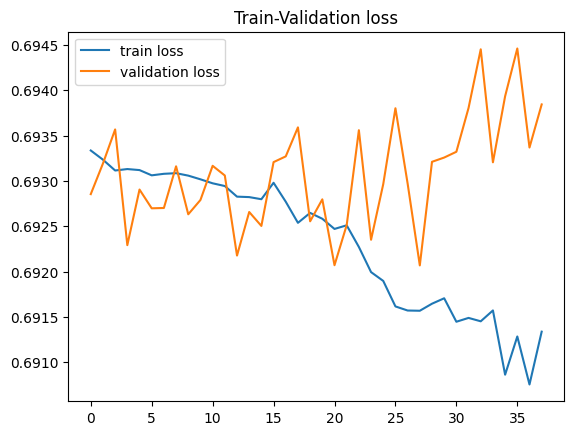

In [56]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [57]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4732142857142857, 'precision': 0.4732142857142857, 'f1': 0.4732142857142857, 'accuracy': 0.4732142857142857}
MALE {'recall': 0.3723958333333333, 'precision': 0.3723958333333333, 'f1': 0.3723958333333333, 'accuracy': 0.3723958333333333}
FEMALE {'recall': 0.57, 'precision': 0.57, 'f1': 0.57, 'accuracy': 0.57} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5277777777777778, 'precision': 0.5277777777777778, 'f1': 0.5277777777777778, 'accuracy': 0.5277777777777778}
MALE {'recall': 0.4768856447688564, 'precision': 0.4768856447688564, 'f1': 0.4768856447688564, 'accuracy': 0.4768856447688564}
FEMALE {'recall': 0.5826771653543307, 'precision': 0.5826771653543307, 'f1': 0.5826771653543307, 'accuracy': 0.5826771653543307} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5215123859191656, 'precision': 0.5215123859191656, 'f1': 0.5215123859191656, 'accuracy': 0.5215123859191656}
MALE {'recall': 0.429292

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934894185240675 	 Validation loss: 0.6928048810716403 	 
  1%|          | 574/57400 [00:05<07:47, 121.46it/s]
Epoch 2 	 Training loss: 0.6932345185337997 	 Validation loss: 0.6924879268064337 	 
  2%|▏         | 1148/57400 [00:10<07:38, 122.74it/s]
Epoch 3 	 Training loss: 0.6932341713938563 	 Validation loss: 0.6930021057694645 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:24, 125.14it/s]
Epoch 4 	 Training loss: 0.6931553938870646 	 Validation loss: 0.6931207180023193 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:31, 122.13it/s]
Epoch 5 	 Training loss: 0.6931522242491254 	 Validation loss: 0.6936330744775675 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:15, 125.14it/s]
Epoch 6 	 Training loss: 0.693092183368962 	 Validation loss: 0.6938935487957324 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:21, 122.25it/s]
Epoch 7 	 Training loss: 0.6929923980285897 	 Valida

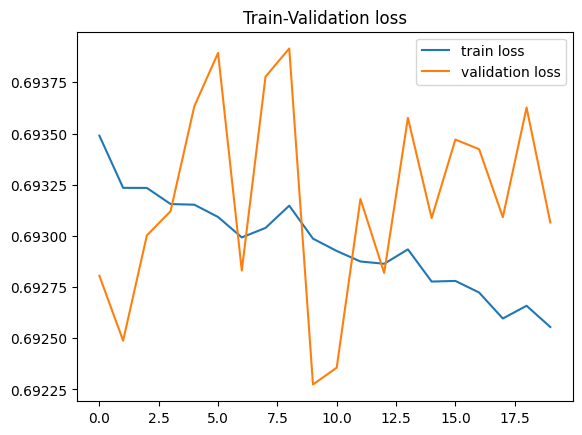

In [58]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [59]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5051020408163265, 'precision': 0.5051020408163265, 'f1': 0.5051020408163265, 'accuracy': 0.5051020408163265}
MALE {'recall': 0.07552083333333333, 'precision': 0.07552083333333333, 'f1': 0.07552083333333333, 'accuracy': 0.07552083333333333}
FEMALE {'recall': 0.9175, 'precision': 0.9175, 'f1': 0.9175, 'accuracy': 0.9175} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48737373737373735, 'precision': 0.48737373737373735, 'f1': 0.48737373737373735, 'accuracy': 0.48737373737373735}
MALE {'recall': 0.08029197080291971, 'precision': 0.08029197080291971, 'f1': 0.08029197080291971, 'accuracy': 0.08029197080291971}
FEMALE {'recall': 0.926509186351706, 'precision': 0.926509186351706, 'f1': 0.926509186351706, 'accuracy': 0.926509186351706} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693354861142328 	 Validation loss: 0.6935399669711872 	 
  1%|          | 574/57400 [00:05<07:43, 122.49it/s]
Epoch 2 	 Training loss: 0.6931574045573378 	 Validation loss: 0.6930348863035946 	 
  2%|▏         | 1148/57400 [00:10<07:36, 123.18it/s]
Epoch 3 	 Training loss: 0.6932175666197667 	 Validation loss: 0.6931361980357412 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:29, 123.75it/s]
Epoch 4 	 Training loss: 0.6931642381156363 	 Validation loss: 0.6925796755289627 	 
  4%|▍         | 2296/57400 [00:20<07:24, 124.04it/s]
Epoch 5 	 Training loss: 0.6931406566905643 	 Validation loss: 0.6923291107355538 	 
  5%|▌         | 2870/57400 [00:25<07:18, 124.49it/s]
Epoch 6 	 Training loss: 0.6930112782671061 	 Validation loss: 0.693033022395635 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:14, 124.15it/s]
Epoch 7 	 Training loss: 0.6930463996290745 	 Validation loss: 0.6926679863768109 	 

2 epoch without improveme

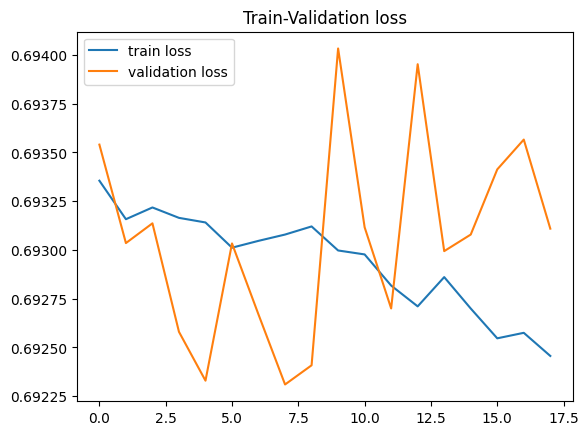

In [60]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [61]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 0.07291666666666667, 'precision': 0.07291666666666667, 'f1': 0.07291666666666667, 'accuracy': 0.07291666666666667}
FEMALE {'recall': 0.89, 'precision': 0.89, 'f1': 0.89, 'accuracy': 0.89} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48737373737373735, 'precision': 0.48737373737373735, 'f1': 0.48737373737373735, 'accuracy': 0.48737373737373735}
MALE {'recall': 0.0948905109489051, 'precision': 0.0948905109489051, 'f1': 0.0948905109489051, 'accuracy': 0.0948905109489051}
FEMALE {'recall': 0.910761154855643, 'precision': 0.910761154855643, 'f1': 0.910761154855643, 'accuracy': 0.910761154855643} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4876140808344198, 'precision': 0.4876140808344198, 'f1': 0.4876140808344198, 'accuracy': 0.4876140808344198}
MALE {'recall': 0.12

In [62]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4893707482993197, 'precision': 0.4893707482993197, 'f1': 0.4893707482993197, 'accuracy': 0.4893707482993197}
Métricas etiqueta male: {'recall': 0.1736111111111111, 'precision': 0.1736111111111111, 'f1': 0.1736111111111111, 'accuracy': 0.1736111111111111}
Métricas etiqueta female:  {'recall': 0.7925, 'precision': 0.7925, 'f1': 0.7925, 'accuracy': 0.7925}

 to
Resultado global: {'recall': 0.5008417508417509, 'precision': 0.5008417508417509, 'f1': 0.5008417508417509, 'accuracy': 0.5008417508417509}
Métricas etiqueta male: {'recall': 0.21735604217356042, 'precision': 0.21735604217356042, 'f1': 0.21735604217356042, 'accuracy': 0.21735604217356042}
Métricas etiqueta female:  {'recall': 0.8066491688538933, 'precision': 0.8066491688538933, 'f1': 0.8066491688538933, 'accuracy': 0.8066491688538933}

 as
Resultado global: {'recall': 0.49760973489787047, 'precision': 0.49760973489787047, 'f1': 0.49760973489787047, 'accuracy': 0.4976097348